In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [3]:
# calculate N*
# N∗=(N−16×P)+2.9
obs['Nstar'] = obs['NO3 (uM)']-(16*obs['PO4 (uM)'])+2.9

# calculate spice
obs['spice'] = gsw.spiciness0(obs['salinity (g kg-1)'], obs['temperature (degC)'])

In [4]:
obs.columns

Index(['Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Al (nM)',
       'Ba (nM)', 'Cd (nM)', 'Co (nM)', 'Cu (nM)', 'Fe (nM)', 'Ga (nM)',
       'Mn (nM)', 'Ni (nM)', 'Pb (nM)', 'Zn (nM)', 'source', 'Nstar', 'spice'],
      dtype='object')

#### remove Salish Sea and Johnstone Strait points

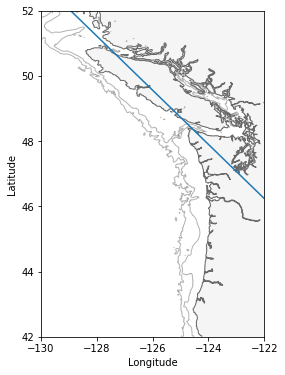

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m
y = m*x+b
ax.plot(x,y)

In [6]:
ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

## Functions

In [38]:
def cluster(key, n):
    # Drop rows with NaN values in the 'salinity' column
    df_clean = obs.dropna(subset=[key])

    # Selecting the property to cluster
    X = df_clean[[key]].values

    # Applying K-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)

    # Assign the cluster labels back to the DataFrame
    df_clean['Cluster'] = kmeans.labels_

    return df_clean[['time','longitude (degrees_east)','latitude (degrees_north)', 'depth (m)',key,'Cluster']]

def multi_cluster(df, keys, n):
    # Drop rows with NaN values in the clustering columns
    df_clean = df.dropna(subset=keys)

    # Selecting the properties to cluster
    X = df_clean[keys].values

    # Normalizing the data
    # you need to do this because you dont want a key with higher values to be more important for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Applying K-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_scaled)

    # Assign the cluster labels back to the DataFrame
    df_clean['Cluster'] = kmeans.labels_

    return df_clean
    
def z_cluster_plot(data, key, n, ax, colour):
    xmin, xmax = np.min(data[key]), np.max(data[key])
    # if xmin < 0:
    #     xmin = 0
    # ymin = np.min(data['depth (m)'])

    cluster_data = data[data['Cluster'] == n]
    
    ax.scatter(cluster_data[key], cluster_data['depth (m)']*-1, s=1,c=colour)

    ax.set_ylabel('Depth (m)')
    ax.set_ylim([-1000,10])
    ax.set_xlim([xmin,xmax])

    plt.tight_layout()

def xy_cluster_plot(data, n, ax, colour):
    cluster_data = data[data['Cluster'] == n]
            
    # Increase font size
    plt.rcParams['font.size'] = 14

    # Make plot area
    ax.set_extent(xlim + ylim)

    # Draw coastline
    ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

    # Draw box
    ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

    # add points
    ax.scatter(cluster_data['longitude (degrees_east)'], cluster_data['latitude (degrees_north)'], s=1,c=colour, transform=crs.PlateCarree(),zorder=7)

    ax.set_title(n)

    plt.tight_layout()

def time_cluster_plot(Cdata):
    # clusters in time versus depth
    time = pd.to_datetime(Cdata.time)
    Cdata['month']=[time[i].month for i in Cdata.index]

    ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

    fig,ax = plt.subplots(1,1,figsize=[6,2])

    for k in Cdata['Cluster'].unique():
        ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k])
    ax2 = ax.twinx()
    ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

    ax2.set_ylabel('Total Count')
    ax.set_xlabel('Month')
    ax.set_ylabel('Fraction of Count')

In [8]:
colours = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

# Single tracer clustering

In [9]:
N=4
xlim, ylim = [-145.5, -120.2], [30, 60]

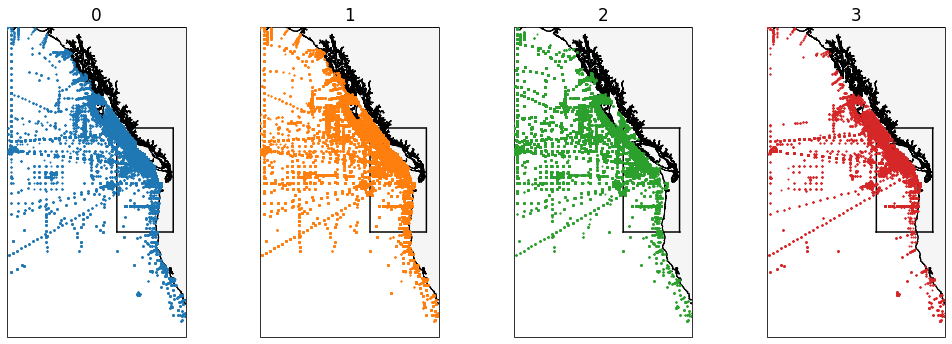

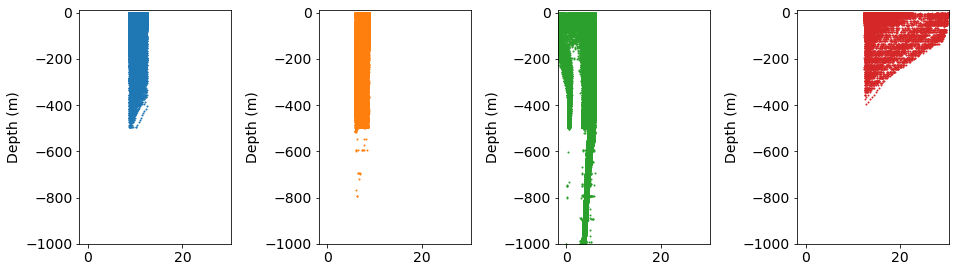

In [10]:
df_cluster = cluster('temperature (degC)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'temperature (degC)', i, ax[i], colours[i])

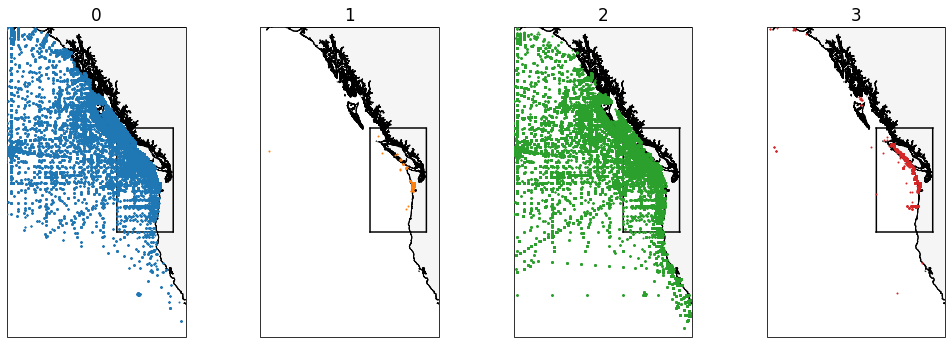

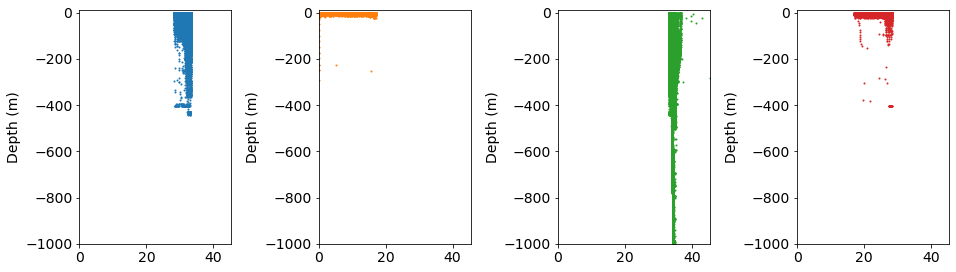

In [11]:
df_cluster = cluster('salinity (g kg-1)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'salinity (g kg-1)', i, ax[i], colours[i])

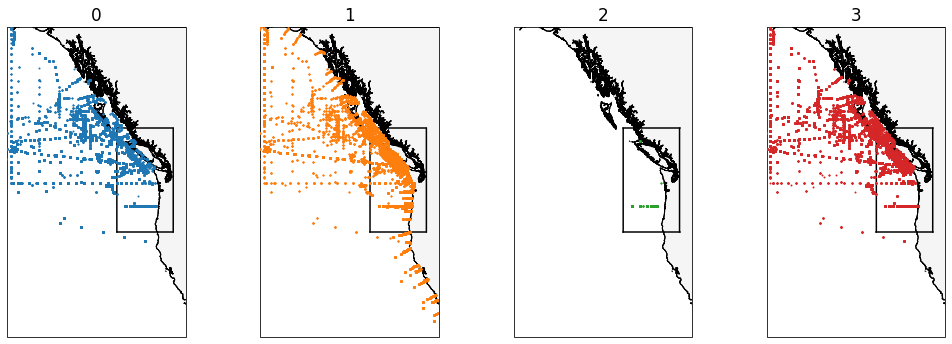

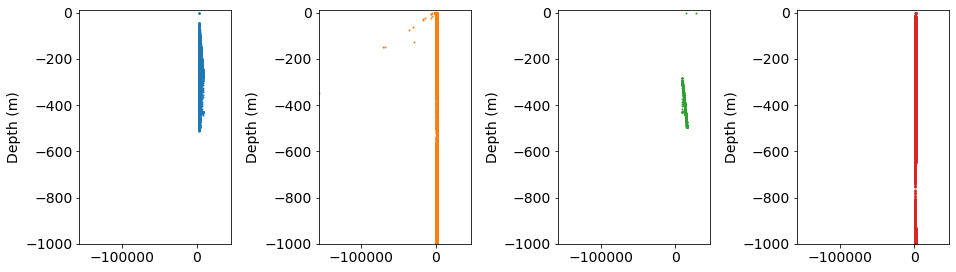

In [12]:
df_cluster = cluster('DO (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'DO (uM)', i, ax[i], colours[i])

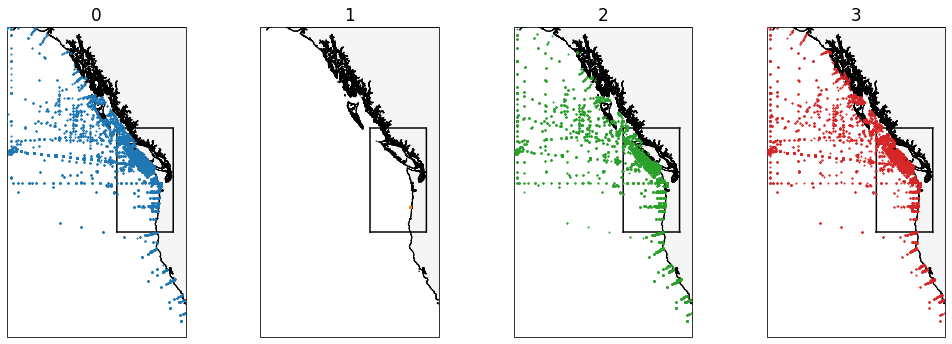

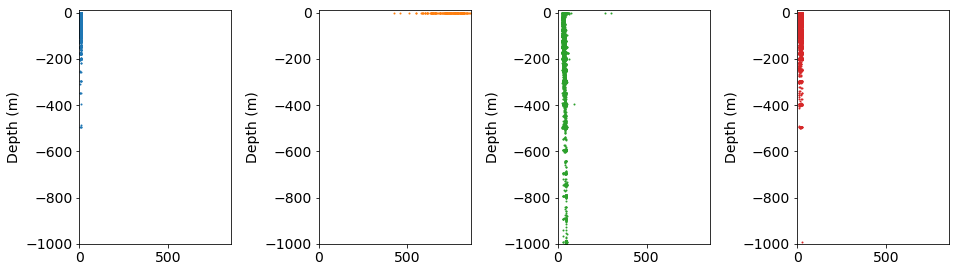

In [13]:
df_cluster = cluster('NO3 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'NO3 (uM)', i, ax[i], colours[i])

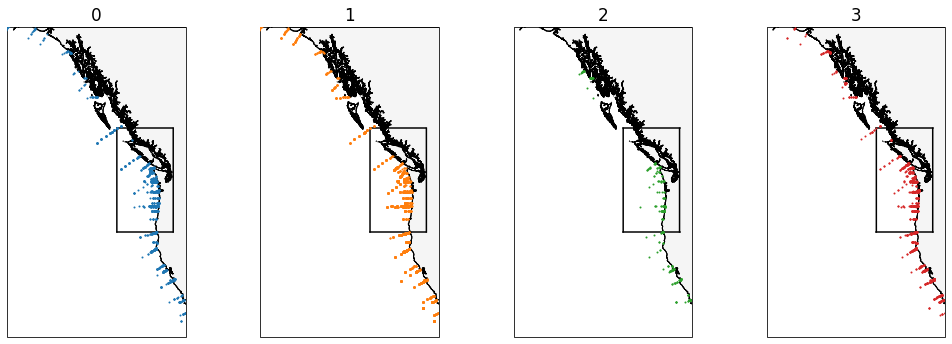

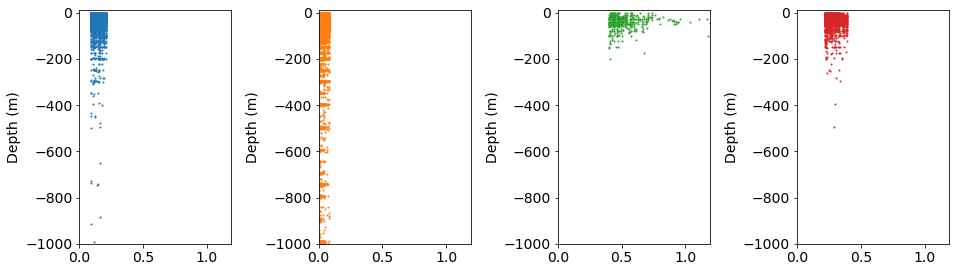

In [14]:
df_cluster = cluster('NO2 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'NO2 (uM)', i, ax[i], colours[i])

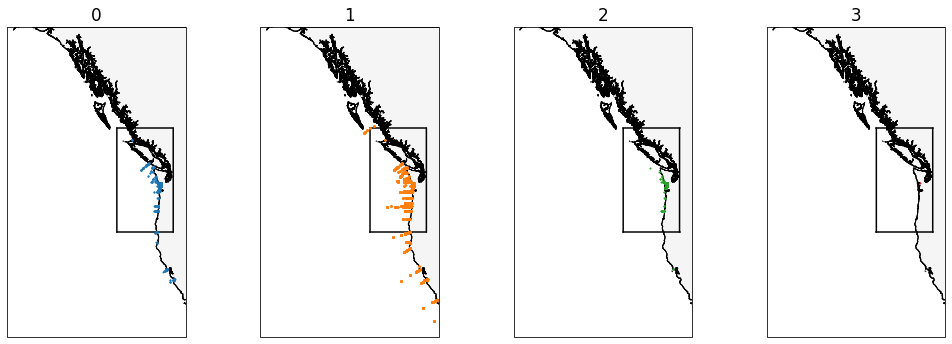

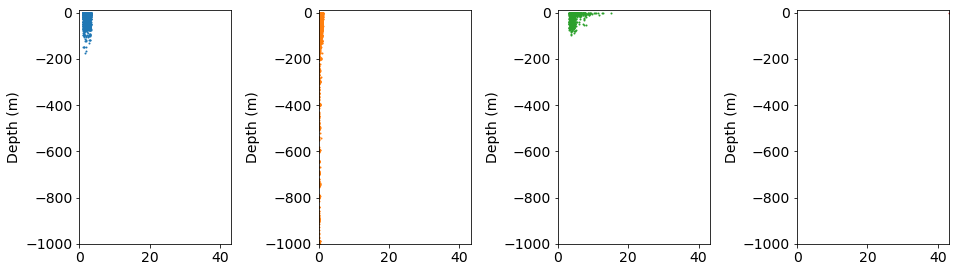

In [15]:
df_cluster = cluster('NH4 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'NH4 (uM)', i, ax[i], colours[i])

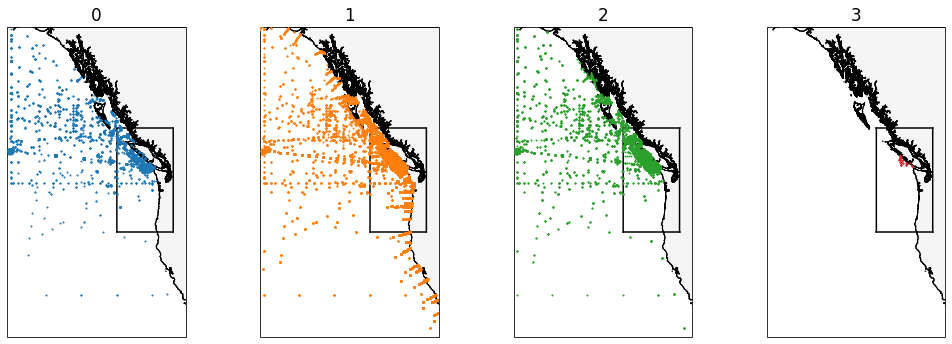

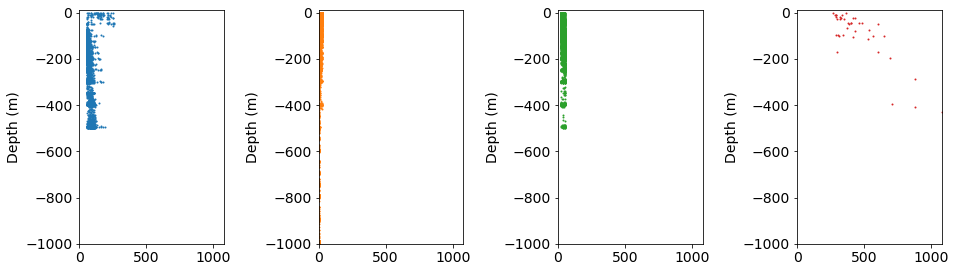

In [16]:
df_cluster = cluster('PO4 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'PO4 (uM)', i, ax[i], colours[i])

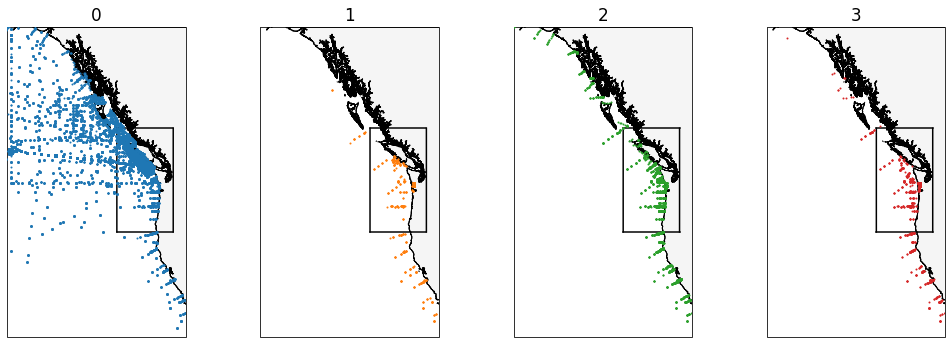

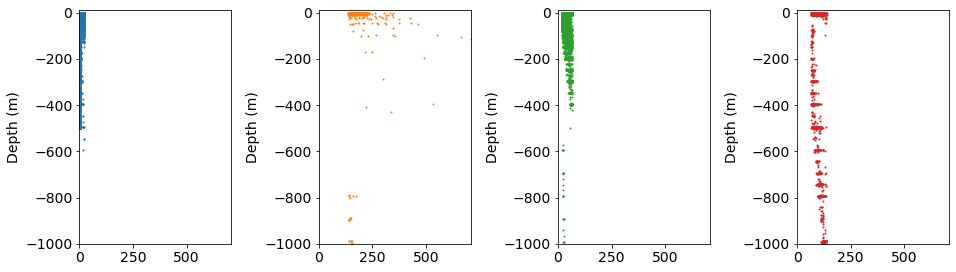

In [17]:
df_cluster = cluster('SiO4 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'SiO4 (uM)', i, ax[i], colours[i])

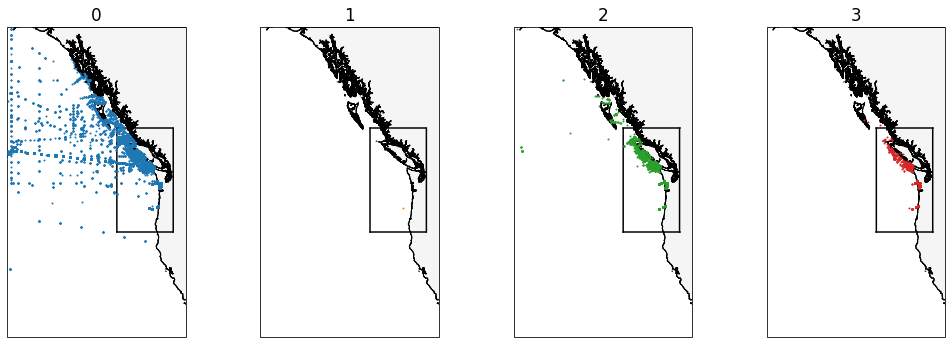

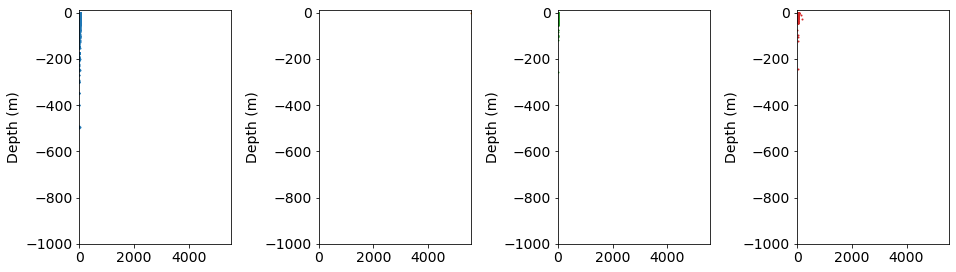

In [18]:
df_cluster = cluster('Chl (mg m-3)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Chl (mg m-3)', i, ax[i], colours[i])

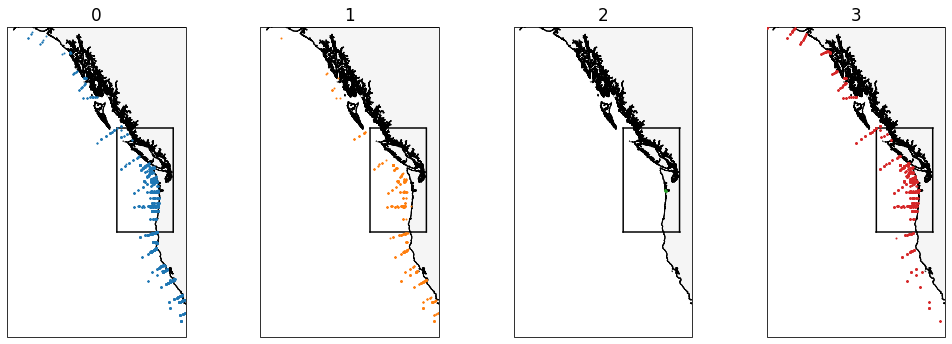

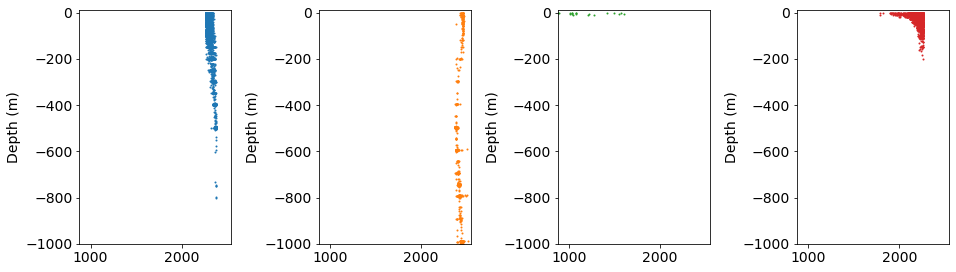

In [19]:
df_cluster = cluster('TA (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'TA (uM)', i, ax[i], colours[i])

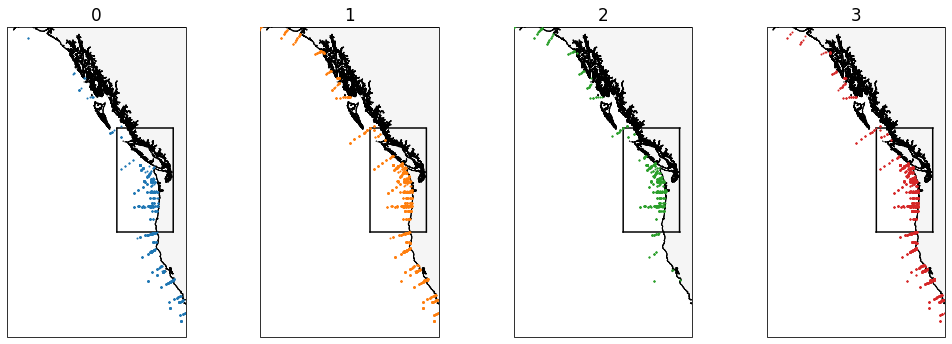

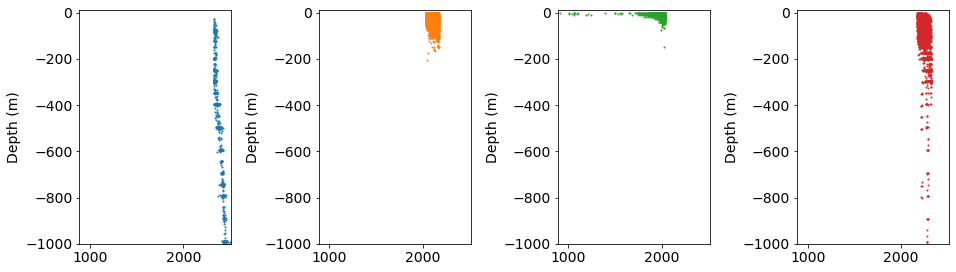

In [20]:
df_cluster = cluster('DIC (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'DIC (uM)', i, ax[i], colours[i])

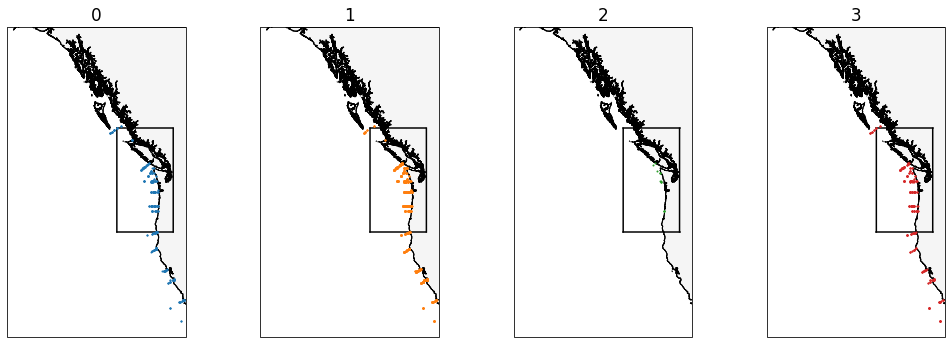

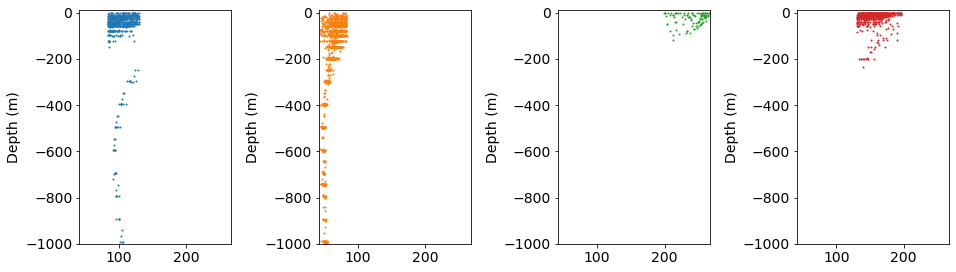

In [21]:
df_cluster = cluster('Carbonate',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Carbonate', i, ax[i], colours[i])

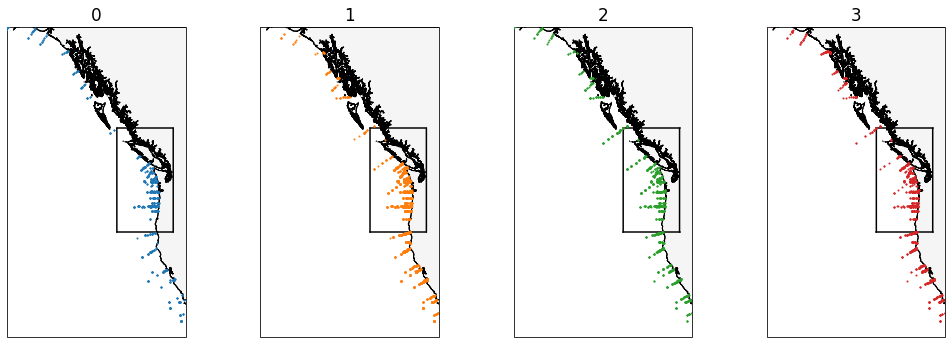

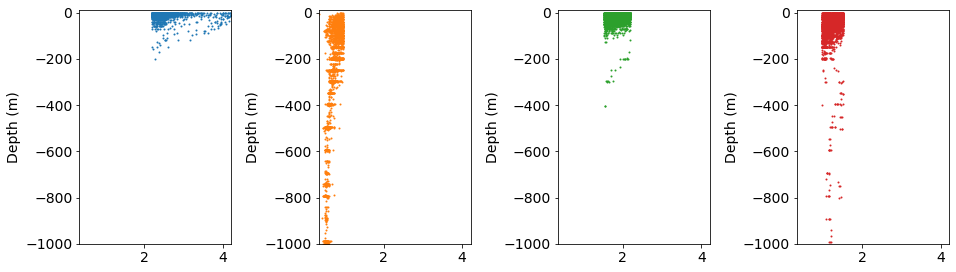

In [22]:
df_cluster = cluster('Aragonite',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Aragonite', i, ax[i], colours[i])

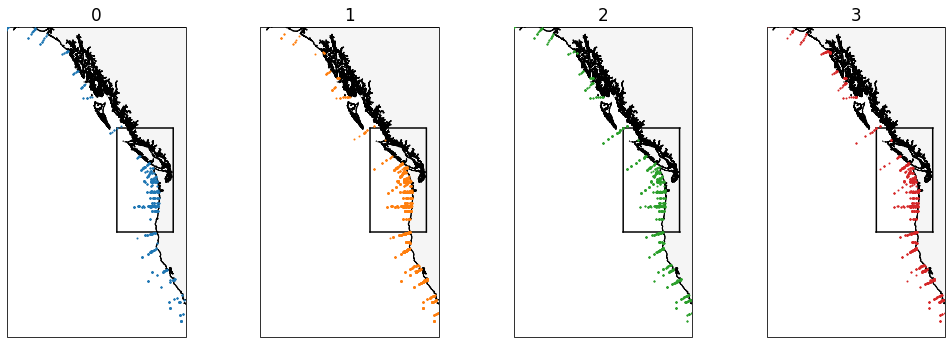

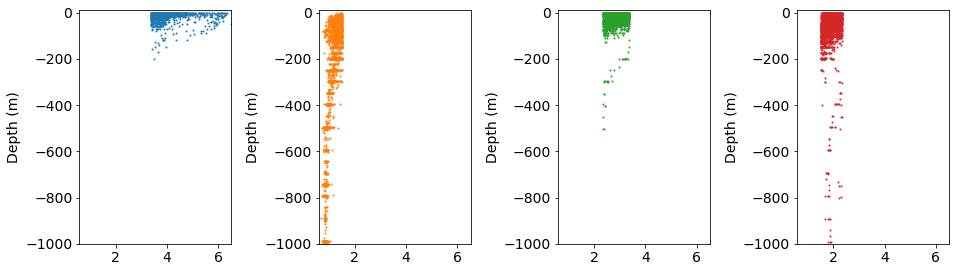

In [23]:
df_cluster = cluster('Calcite',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Calcite', i, ax[i], colours[i])

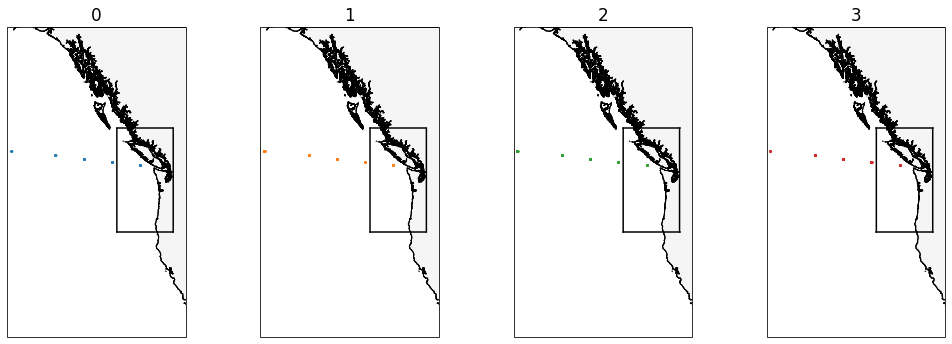

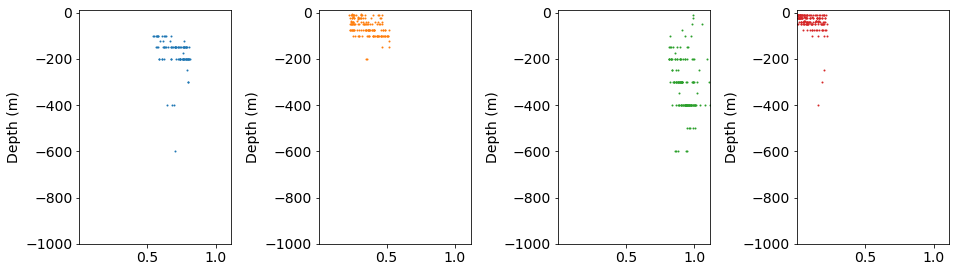

In [24]:
df_cluster = cluster('Cd (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Cd (nM)', i, ax[i], colours[i])

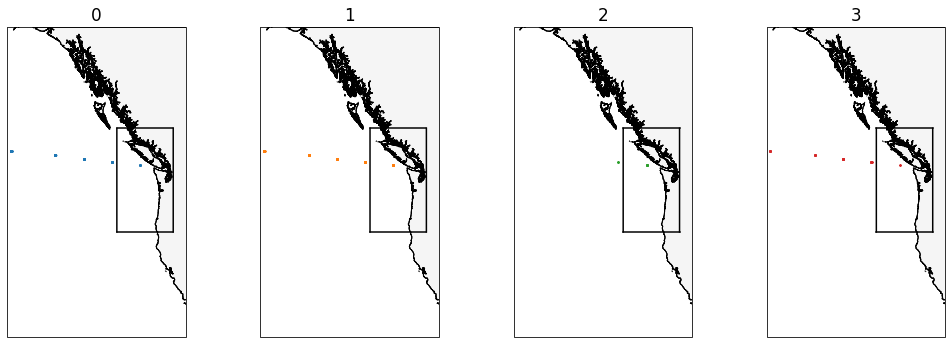

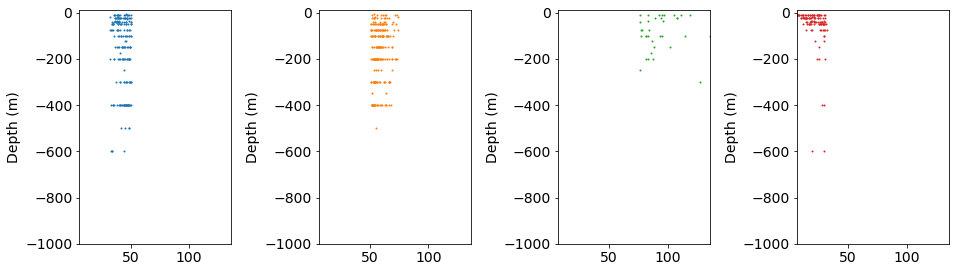

In [25]:
df_cluster = cluster('Co (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Co (nM)', i, ax[i], colours[i])

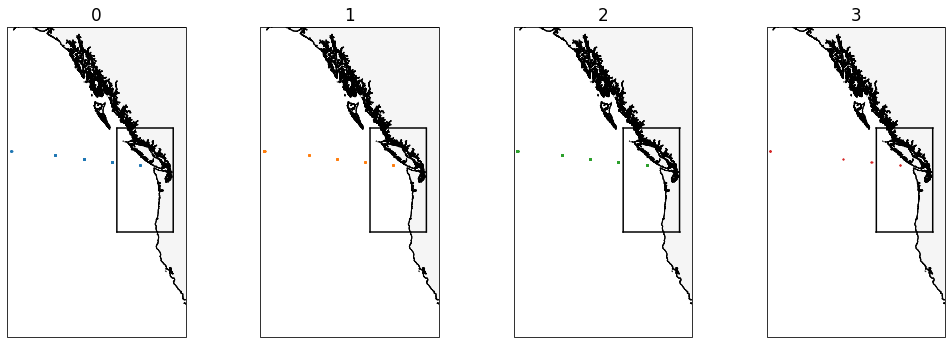

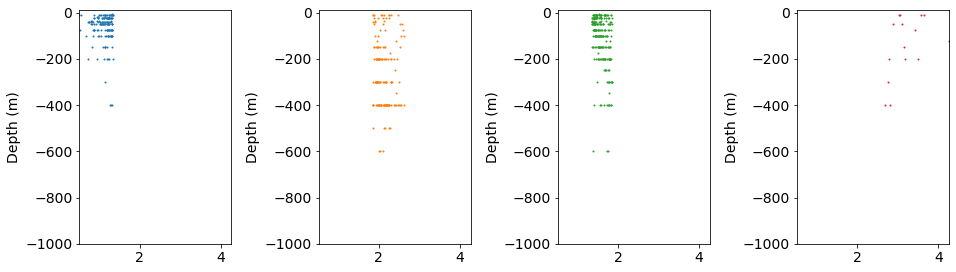

In [26]:
df_cluster = cluster('Cu (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Cu (nM)', i, ax[i], colours[i])

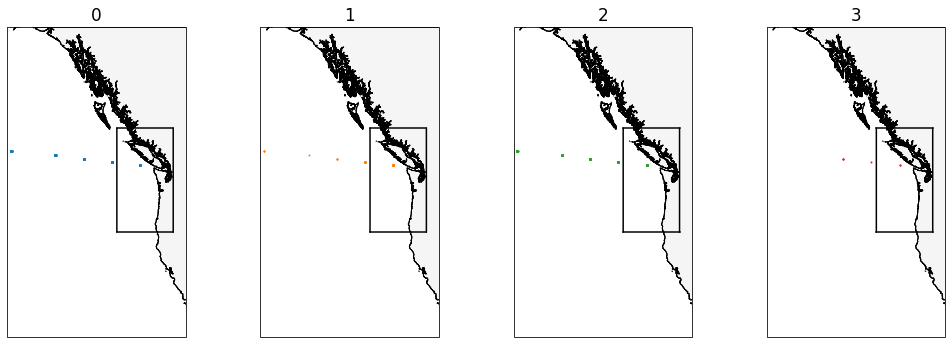

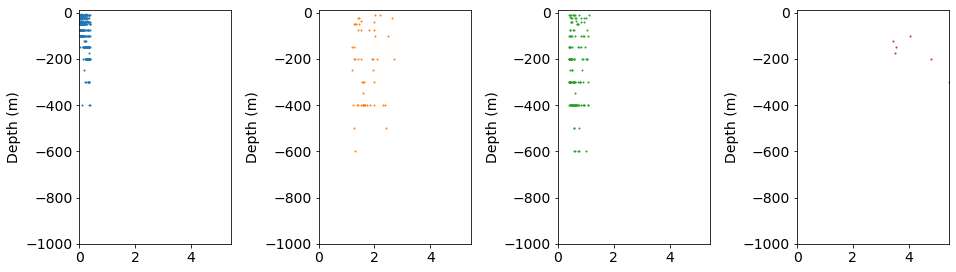

In [27]:
df_cluster = cluster('Fe (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Fe (nM)', i, ax[i], colours[i])

# Multi property clustering

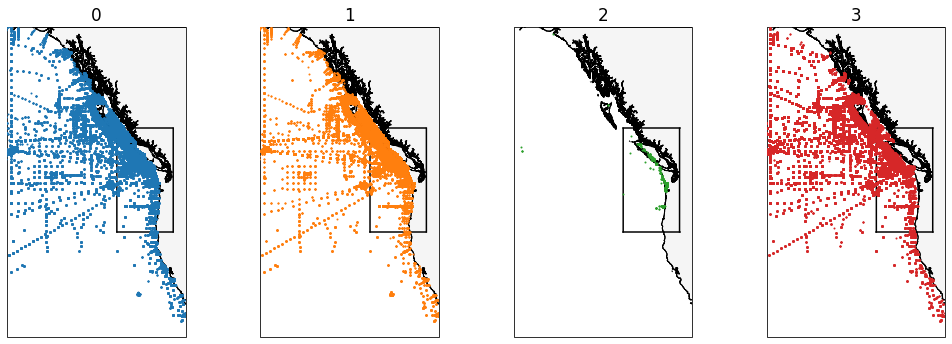

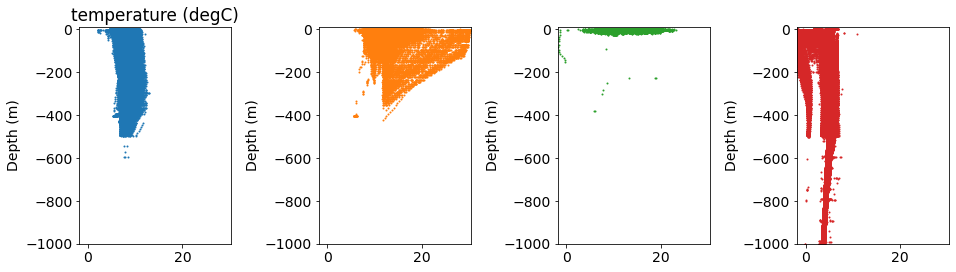

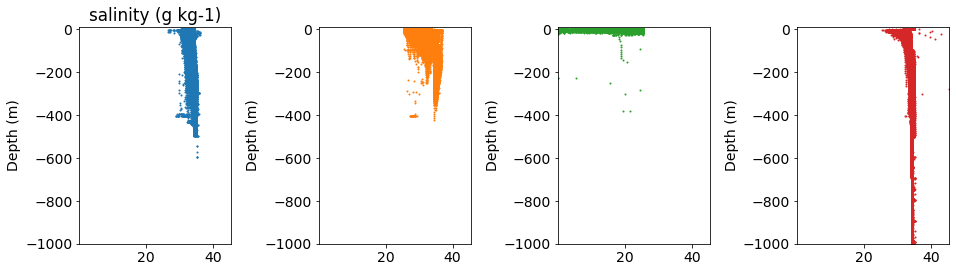

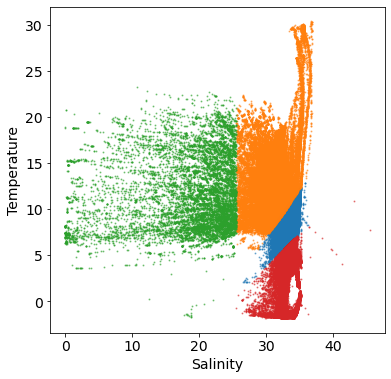

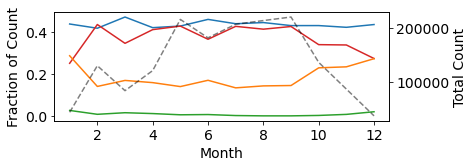

In [40]:
keys = ['temperature (degC)', 'salinity (g kg-1)']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(N):
    ax.scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['temperature (degC)'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
ax.set_ylabel('Temperature')
ax.set_xlabel('Salinity')

time_cluster_plot(df_cluster)
    

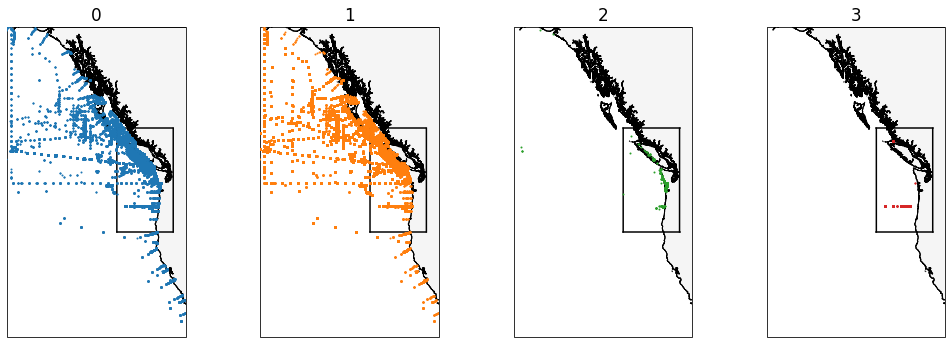

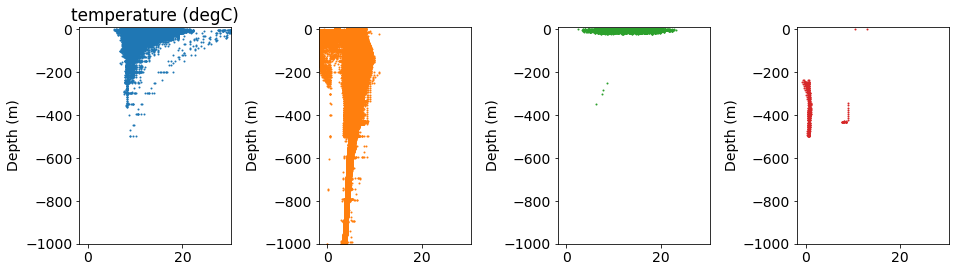

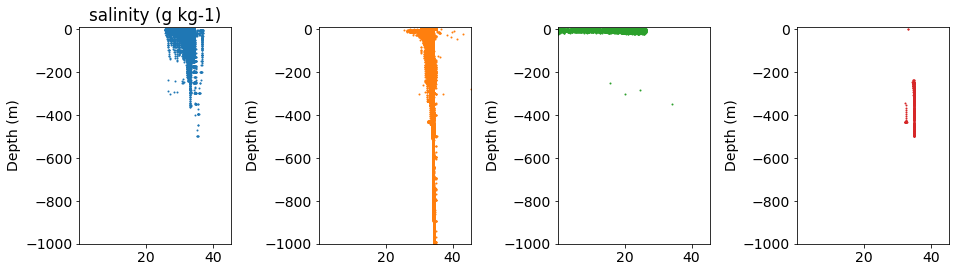

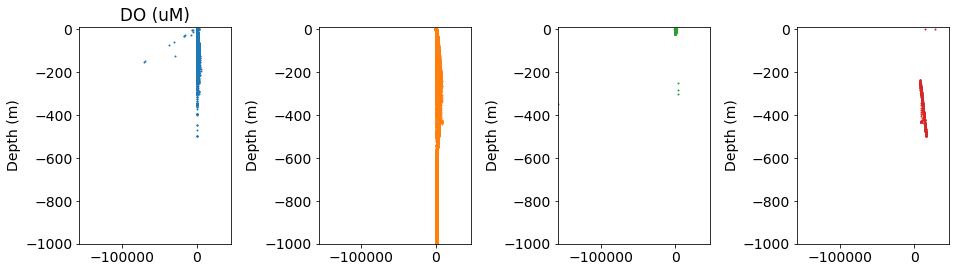

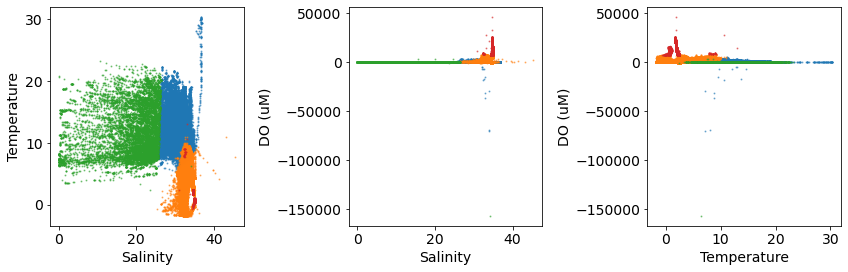

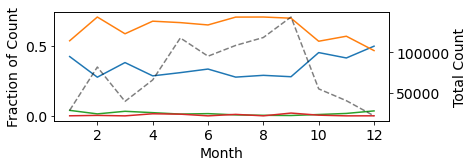

In [41]:
keys = ['temperature (degC)', 'salinity (g kg-1)', 'DO (uM)']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[2])
for i in range(N):
    z_cluster_plot(df_cluster, keys[2], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,3,figsize = (12,4))
for i in range(N):
    ax[0].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['temperature (degC)'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
    ax[1].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['DO (uM)'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
    ax[2].scatter(df_cluster['temperature (degC)'][df_cluster.Cluster == i],df_cluster['DO (uM)'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])

ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('DO (uM)')
ax[2].set_ylabel('DO (uM)')

ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[2].set_xlabel('Temperature')

plt.tight_layout()

time_cluster_plot(df_cluster)


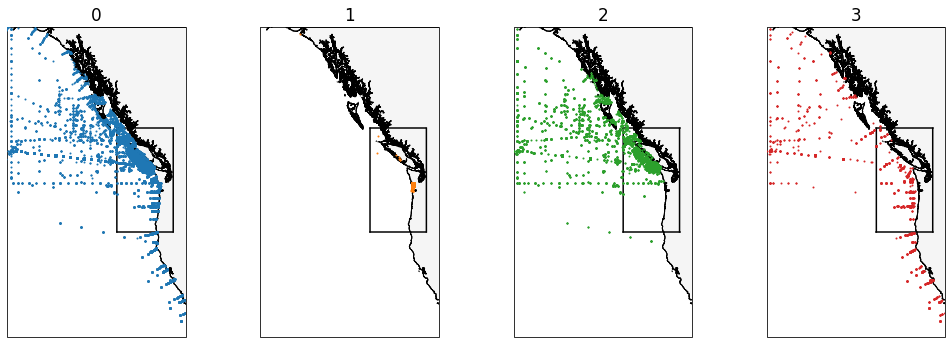

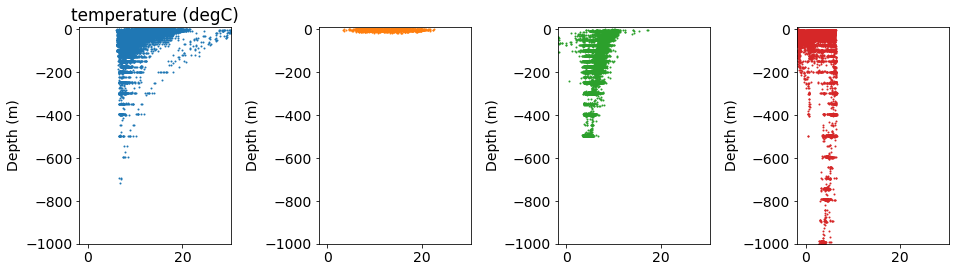

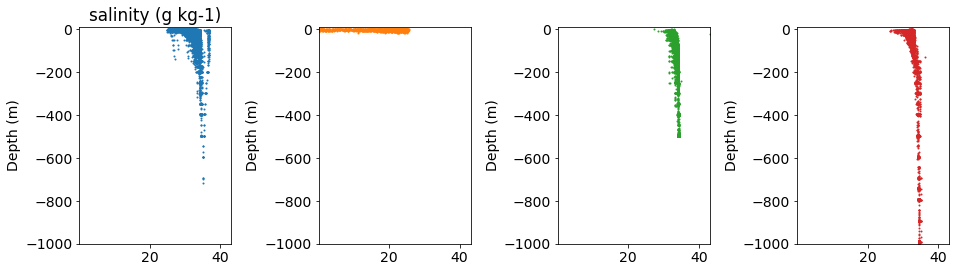

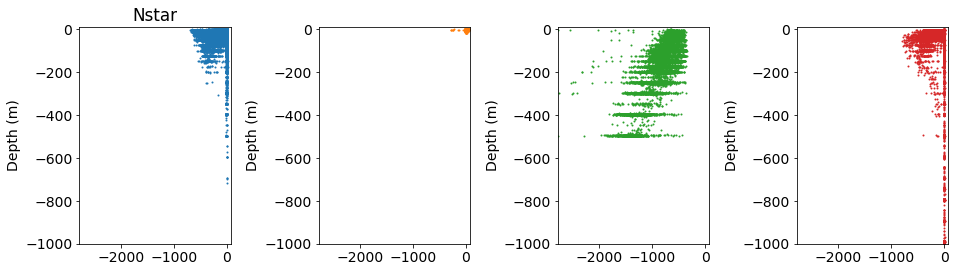

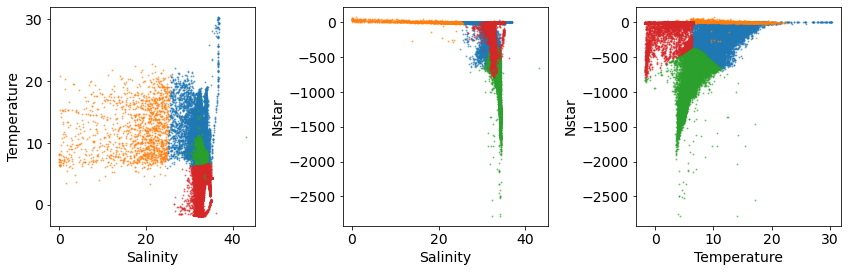

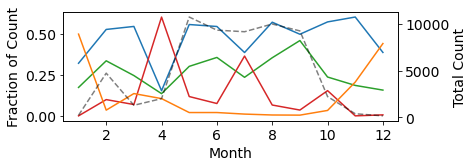

In [42]:
keys = ['temperature (degC)', 'salinity (g kg-1)', 'Nstar']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[2])
for i in range(N):
    z_cluster_plot(df_cluster, keys[2], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,3,figsize = (12,4))
for i in range(N):
    ax[0].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['temperature (degC)'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
    ax[1].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['Nstar'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
    ax[2].scatter(df_cluster['temperature (degC)'][df_cluster.Cluster == i],df_cluster['Nstar'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])

ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('Nstar')
ax[2].set_ylabel('Nstar')

ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[2].set_xlabel('Temperature')

plt.tight_layout()

time_cluster_plot(df_cluster)


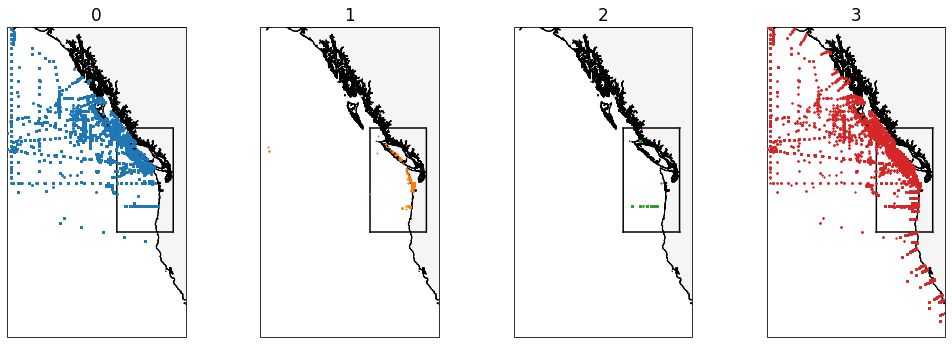

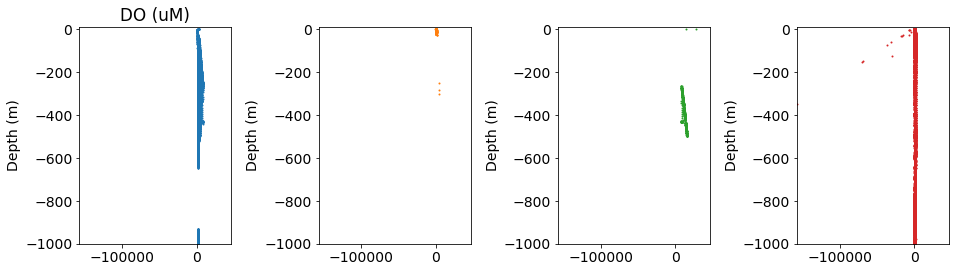

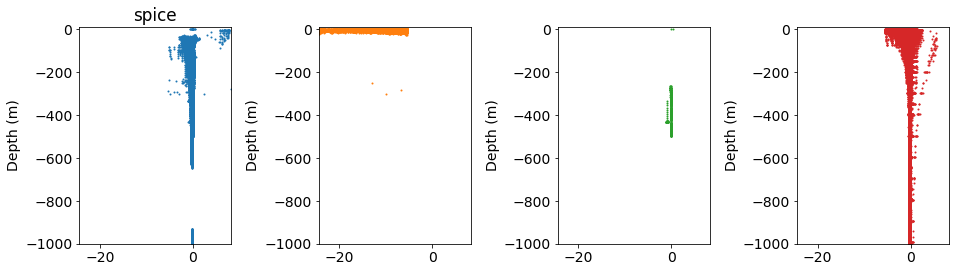

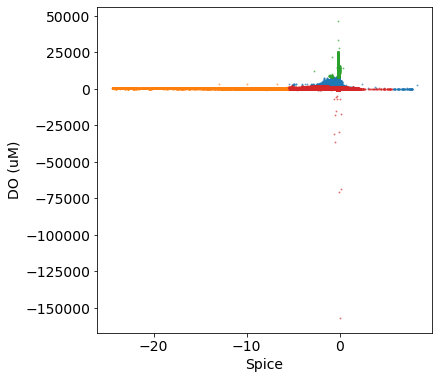

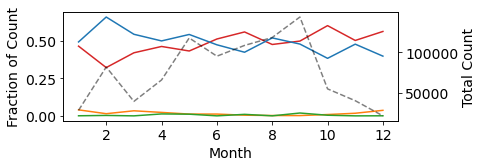

In [43]:
keys = ['DO (uM)', 'spice']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(N):
    ax.scatter(df_cluster['spice'][df_cluster.Cluster == i],df_cluster['DO (uM)'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
ax.set_ylabel('DO (uM)')
ax.set_xlabel('Spice')
    

time_cluster_plot(df_cluster)

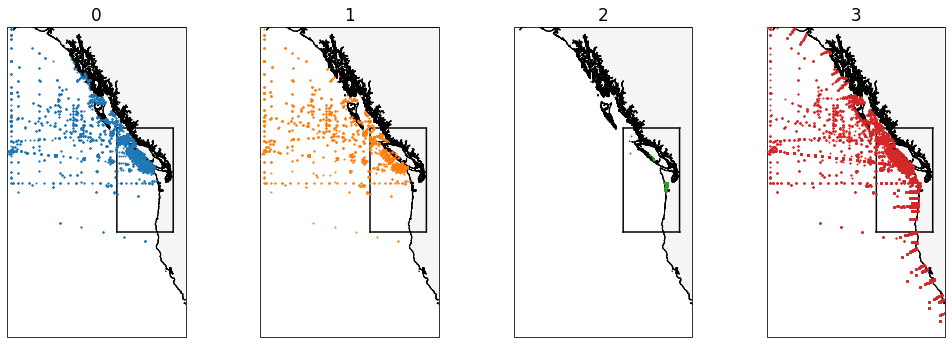

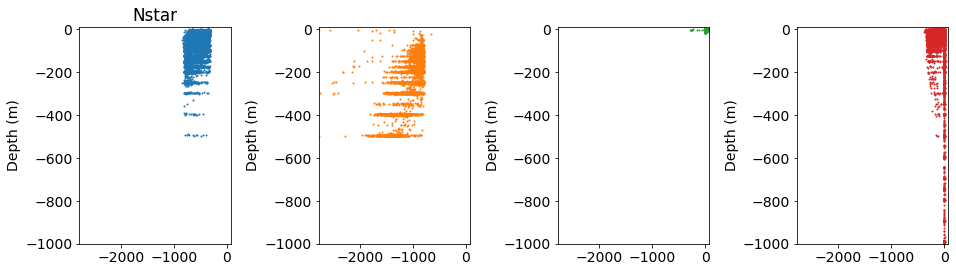

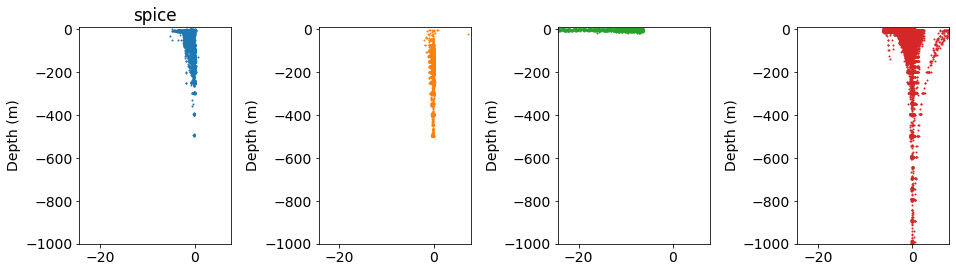

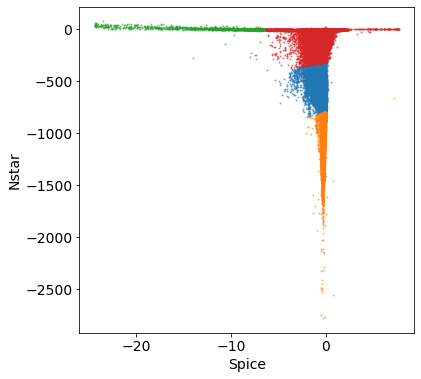

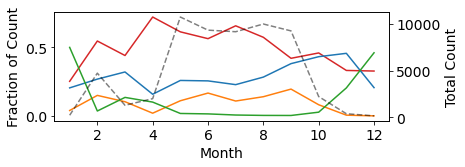

In [44]:
keys = ['Nstar', 'spice']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(N):
    ax.scatter(df_cluster['spice'][df_cluster.Cluster == i],df_cluster['Nstar'][df_cluster.Cluster == i],s=1,alpha=0.5,c=colours[i])
ax.set_ylabel('Nstar')
ax.set_xlabel('Spice')

time_cluster_plot(df_cluster)